### Метрики классификации.


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
sklearn.set_config(transform_output="pandas")
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler

import optuna

In [2]:
data = pd.read_csv("aux/microsoft_malware_detection.csv")

In [107]:
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Перед вами пердобработанный датасет от Microsoft. столбец  `HasDetections` - ваш таргет. Который отражает по имеющимся данным, данная программа является вирусом или нет. Датасет имеет дисбаланс классов. Хороша ли метрика `accuracy`?

Нет, метрика accuracy будет ужасным показателем. Если весь таргет подставить как 0, то получим точность 83.31, т.к. имеется явный дисбаланс классов(83.31 против 16.69)

1. Проверьте пропорцию классов

In [9]:
data['HasDetections'].value_counts(normalize=True) * 100

HasDetections
0    83.31666
1    16.68334
Name: proportion, dtype: float64

2. Сделайте scaling данных

In [38]:
X, y = data.drop('HasDetections', axis=1), data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_test_scaled

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows7,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN
80926,0.845075,0.591666,0.588516,0.163286,-0.143190,0.438940,-0.683220,-0.140065,0.113431,-0.236007,...,-0.104368,-0.147637,0.341151,-0.340903,-0.043831,-0.01164,-0.340408,0.360117,-0.159476,-0.047607
44468,-0.025911,0.591666,0.427237,0.163286,-0.143190,-2.557605,1.134477,-0.140065,0.113431,-0.840186,...,-0.104368,-0.147637,-2.931256,2.933384,-0.043831,-0.01164,2.937653,0.360117,-0.159476,-0.047607
25069,-0.117091,-1.287718,-0.581949,0.163286,-0.143190,0.438940,-0.683220,-0.140065,0.113431,-1.189974,...,-0.104368,-0.147637,0.341151,-0.340903,-0.043831,-0.01164,-0.340408,0.360117,-0.159476,-0.047607
25283,0.845075,-0.618309,0.266752,0.163286,-0.143190,0.438940,-0.683220,-0.140065,0.113431,0.527167,...,-0.104368,-0.147637,-2.931256,2.933384,-0.043831,-0.01164,2.937653,0.360117,-0.159476,-0.047607
110050,-0.025911,0.591666,-0.693041,0.163286,-0.143190,-0.024286,1.134477,-0.140065,0.113431,-0.633493,...,-0.104368,-0.147637,0.341151,-0.340903,-0.043831,-0.01164,-0.340408,0.360117,-0.159476,-0.047607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56272,-0.025911,-3.046895,-0.595124,0.163286,-0.143190,0.438940,-0.683220,-0.140065,0.113431,-0.760688,...,-0.104368,-0.147637,-2.931256,2.933384,-0.043831,-0.01164,2.937653,0.360117,-0.159476,-0.047607
3094,-1.595151,-1.238145,-4.218052,0.163286,-0.143190,-0.681784,1.134477,-0.140065,0.113431,1.687826,...,-0.104368,-0.147637,0.341151,-0.340903,-0.043831,-0.01164,-0.340408,0.360117,-0.159476,-0.047607
83660,-0.856110,0.914803,-0.307398,0.163286,-0.143190,0.438940,-0.683220,-0.140065,0.113431,1.131346,...,-0.104368,-0.147637,0.341151,-0.340903,-0.043831,-0.01164,-0.340408,-2.776879,6.270546,-0.047607
19413,-0.025911,0.591666,0.327076,-6.260738,6.983717,0.490439,1.134477,-0.140065,0.113431,-1.253571,...,-0.104368,-0.147637,0.341151,-0.340903,-0.043831,-0.01164,-0.340408,0.360117,-0.159476,-0.047607


Произведем процедуру отложенной выборки:

3. Создайте разделение на тренировочную и валидационную выборку, постройте модель Логистической регрессии, попробуйте настроить коэффициент регуляризации(С) с помощью `optuna`

Best C: 0.0002442993468348441
Best cross-validated accuracy: 0.8331499274017391
Best C: 469.53380613748385
Best cross-validated accuracy: 0.8331499274017391
array([[24726,   293],
       [ 4442,   527]])

In [48]:
def objective(trial):
    C = trial.suggest_float('C', 1e-5, 100, log=True)
    model = LogisticRegression(C=C, class_weight='balanced' ,solver='liblinear', random_state=42)
    
    scores = cross_val_score(model,X_train_scaled, y_train, cv=5, scoring='f1')
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=3)


best_trial = study.best_trial
print("Best F1 Score:", best_trial.value)
print("Best C:", best_trial.params['C'])

[I 2024-10-30 15:23:51,282] A new study created in memory with name: no-name-13f825a0-a25f-4a5b-be4c-4b07f3f66e27
[I 2024-10-30 15:23:58,919] Trial 2 finished with value: 0.36465730629506016 and parameters: {'C': 0.00014001384077141058}. Best is trial 2 with value: 0.36465730629506016.
[I 2024-10-30 15:24:01,867] Trial 1 finished with value: 0.3670548657066948 and parameters: {'C': 0.0006173079141088531}. Best is trial 1 with value: 0.3670548657066948.
[I 2024-10-30 15:24:11,301] Trial 3 finished with value: 0.3673188778719217 and parameters: {'C': 0.001846758467451146}. Best is trial 3 with value: 0.3673188778719217.
[I 2024-10-30 15:24:16,029] Trial 4 finished with value: 0.36771020474254357 and parameters: {'C': 0.003376754909220459}. Best is trial 4 with value: 0.36771020474254357.
[I 2024-10-30 15:24:23,332] Trial 5 finished with value: 0.3672600760921558 and parameters: {'C': 0.0016540430080944982}. Best is trial 4 with value: 0.36771020474254357.
[I 2024-10-30 15:24:46,741] Tria

Best F1 Score: 0.3679241920664463
Best C: 0.005768785991595511


4.  Постройте __confusion matrix__ на тестовой выборки. Отобразите ее в виде DataFrame

|          | y_real = 1  | y_real = 0  |
|----------|------------|------------|
|  y_pred = 1  |     TP     |     FP     |
|  y_pred = 0  |     FN     |     TN     |  

Напоминаю:

* Positive/Negative отражает то, к какому классу определила объект наша модель, в нашем случае нулевой класс соответствует Negative (нет вируса), а единичный класс - Positive (есть вирус).

* True/False просто показывает совпало ли предсказание модели с реальным классом объекта, поэтому на главной диагонали стоят True, а на побочной False.

In [52]:
lr = LogisticRegression(C=0.006, class_weight='balanced', solver='liblinear', random_state=42)

In [92]:
### Your code is here
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_train_scaled)

TP = 0
TN = 0
FP = 0
FN = 0

for true, pred in zip(y_train, y_pred):
    if true == 1 and pred == 1:
        TP += 1
    elif true == 0 and pred == 0:
        TN += 1
    elif true == 0 and pred == 1:
        FP += 1
    elif true == 1 and pred == 0:
        FN += 1

confus_matrix = np.array([[TP, FP], 
                             [FN, TN]])

confusion_df = pd.DataFrame(confus_matrix, index=['y_pred = 1', 'y_pred = 0'], columns=['y_real = 1', 'y_real = 0'])
print(confusion_df)


            y_real = 1  y_real = 0
y_pred = 1       10326       29441
y_pred = 0        5712       50482


5. Сравните результат с методом `confusion_matrix` в `sklearn.metrics`. Обратите внимание на тот факт, что в sklearn матрица транспонирована относительно нашей

In [61]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_train, y_pred))

,0,1
0,50482,29441
1,5712,10326


6. Посчитайте `accuracy`, `precision`, `recall`

In [117]:
### Your code is here
acc = (TP + TN) / (TP + FP + FN + TN) 
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print(acc, precision, recall)

0.6336740967684789 0.2596625342620766 0.6438458660680882


In [115]:
from sklearn.metrics import recall_score, precision_score

### Your code is here
print(recall_score(y_train, y_pred), precision_score(y_train, y_pred))

0.6438458660680882 0.2596625342620766


7. Какая метрика более точно описывает происходящее? Хороший ли результат мы получили

In [118]:
from sklearn.metrics import f1_score

### Your code is here
print(f"""Наша точность определения вируса: {round(precision, 3) * 100} %
Но процент нахождения вируса {round(recall, 3) * 100} % 
Точность (accuracy) вводит в заблуждение {round(acc, 3) * 100} % 
А вот f1-score показывает настоящее значение точности нашей модели {round(f1_score(y_train, y_pred), 2)}
Надо сделать помарку, что f1-score в диапазоне 0-0.5 (модель слабая) 
А если меньше нуля, то вообще все плохо. 
По факту модель не справляется т.к. 0.5 все еще больше. 
В случае когда классы имеют явный дисбаланс, то лучше использовать f1-score
В данном случае можно использовать recall, т.к нам важен процент обнаружения вируса""")

Наша точность определения вируса: 26.0 %
Но процент нахождения вируса 64.4 % 
Точность (accuracy) вводит в заблуждение 63.4 % 
А вот f1-score показывает настоящее значение точности нашей модели 0.37
Надо сделать помарку, что f1-score в диапазоне 0-0.5 (модель слабая) 
А если меньше нуля, то вообще все плохо. 
По факту модель не справляется т.к. 0.5 все еще больше. 
В случае когда классы имеют явный дисбаланс, то лучше использовать f1-score
В данном случае можно использовать recall, т.к нам важен процент обнаружения вируса


8. Допустим, руководитель требует, чтобы наш классификатор в 60% случаев правильно предсказывал наличие вируса на компьютере, чтобы не беспокоить клиентов из-за ложноположительных результатов. \
Как решить эту задачу? =>
Надо подобрать порог, который максимизирует `recall` при условии, что `precision > 0.6`.

$$
(recall | precision > 0.6) \to \max_{thres}
$$

Для этого возможно построить так называемую `precision_recall_curve`, которая поможет нам посмотреть при разных трешхолдах соотношения этих двух метрик и вырать оптимальное

In [119]:
from sklearn.metrics import precision_recall_curve

### Строим всевозможные комбинации precision, recall, threshold
y_scores = lr.predict_proba(X_test_scaled)[:, 1]

precision, recall, thres = precision_recall_curve(y_test, y_scores)

### Находим такую тройку, при которой recall максимален, а precision > 0.6

ind = np.where(recall == recall[precision > 0.6].max())

print(f"Precison:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {thres[ind][-1]}")

Precison:	 0.6016355140186916
Recall: 	 0.1295923502767992
Threshold:	 0.8042747169595535


Теперь чтобы соответствовать установленным условиям, мы будем замерять вероятности для объектов и сравнивать и с найденным `Threshold`, который решает нашу задачу

9. На примере того, что сделано  решите задачу, где заказчик требует, чтобы наш классификатор находил хотя бы 20% компьютеров с вирусом, среди всех действительно зараженных компьютеров.
$$
(precision | recall > 0.2) \to \max_{thres}
$$

In [120]:
### Your code is here

precision, recall, thres = precision_recall_curve(y_test, y_scores)

ind = np.where(precision == precision[recall > 0.2].max())

print(f"Precison:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {thres[ind][-1]}")

Precison:	 0.49843847595252966
Recall: 	 0.2008052340211374
Threshold:	 0.7088451608108038


10. Одним из самых распространенных показателей качества является **F-мера**, которая обобщает все вышерассмотренные метрики. Более того, в ней можно регулировать параметр $\beta^2$, который отвечает за предпочтение между precision и recall. 
$$
F = \dfrac{(1 + \beta^2) P \cdot R}{\beta^2 P + R}
$$
* При $\beta^2 = 1$ и precision, и recall нам важны в равной степени.
* При $\beta^2 > 1$ предпочтение отдается recall. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение precision и максимизируем recall.
* При $0 < \beta^2 < 1$ предпочтение отдается precision. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение recall и максимизируем precision.

Найдите порог, который максимизирует:
1) F-меру с $\beta^2 = 1$,
2) F-меру с $\beta^2 = 0.05$,
3) F-меру с $\beta^2 = 4$.\
Для всех трех случаев выведите precision, recall, threshold и F-меру. 
Нарисуйте линии уровня и точку, которая максимизирует F-меру по аналогии с предыдущим пунктом.

In [128]:
beta = 1
f_score = ((1 + beta) * precision * recall) / beta *(precision + recall)

f_score_index = np.argmax(f_score)
f_score_max = f_score[f_score_index]

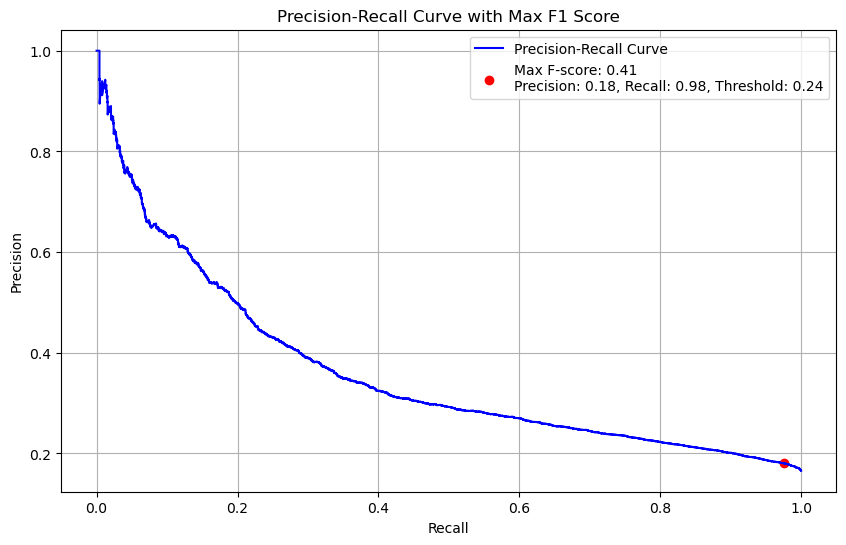

In [130]:
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label="Precision-Recall Curve", color='blue')
plt.scatter(recall[f_score_index], precision[f_score_index], color='red', label=f"Max F-score: {f_score_max:.2f}\nPrecision: {precision[f_score_index]:.2f}, Recall: {recall[f_score_index]:.2f}, Threshold: {thres[f_score_index]:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Max F1 Score")
plt.legend()
plt.grid(True)
plt.show()

In [135]:
beta = 0.05
f_score = ((1 + beta) * precision * recall) / beta *(precision + recall)

f_score_index = np.argmax(f_score)
f_score_max = f_score[f_score_index]

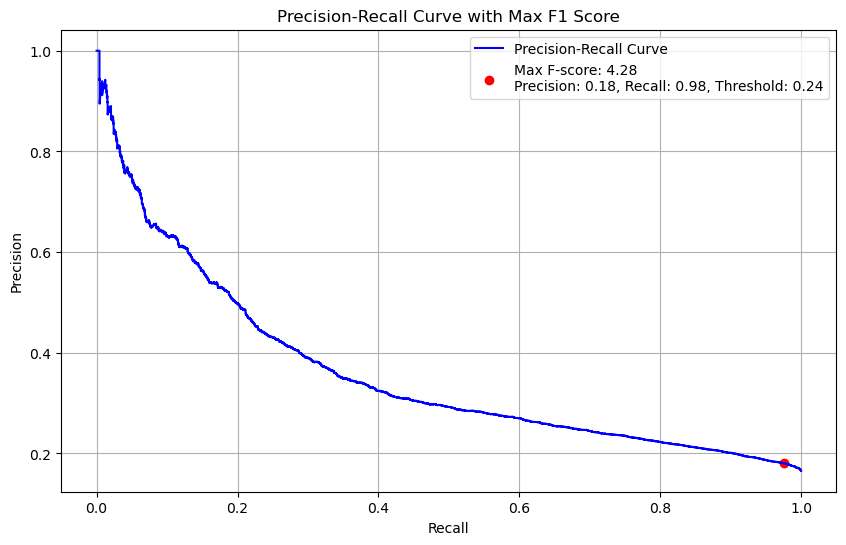

In [139]:
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label="Precision-Recall Curve", color='blue')
plt.scatter(recall[f_score_index], precision[f_score_index], color='red', label=f"Max F-score: {f_score_max:.2f}\nPrecision: {precision[f_score_index]:.2f}, Recall: {recall[f_score_index]:.2f}, Threshold: {thres[f_score_index]:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Max F1 Score")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
beta = 4
f_score = ((1 + beta) * precision * recall) / beta *(precision + recall)

f_score_index = np.argmax(f_score)
f_score_max = f_score[f_score_index]

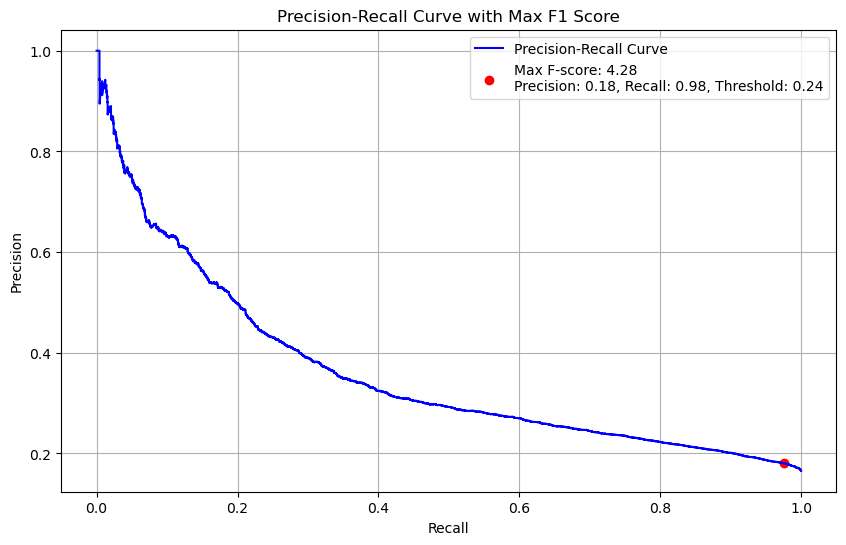

In [137]:
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label="Precision-Recall Curve", color='blue')
plt.scatter(recall[f_score_index], precision[f_score_index], color='red', label=f"Max F-score: {f_score_max:.2f}\nPrecision: {precision[f_score_index]:.2f}, Recall: {recall[f_score_index]:.2f}, Threshold: {thres[f_score_index]:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Max F1 Score")
plt.legend()
plt.grid(True)
plt.show()

11. Постройте roc-auc.  
Пример описан снизу

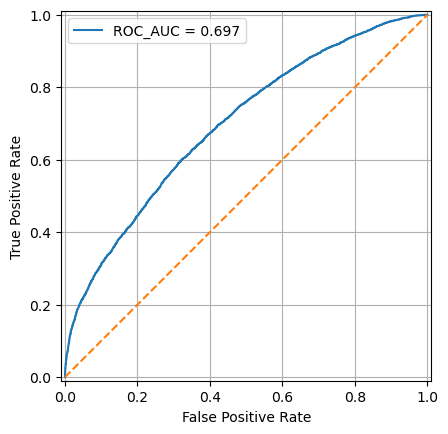

In [149]:
from sklearn.metrics import roc_curve, roc_auc_score

x = np.linspace(0, 1, 100)
roc_auc = np.round(roc_auc_score(y_test, y_scores), 3)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# # И нарисуем ROC-кривую

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay(fpr=fpr, tpr=tpr).plot(label=f'ROC_AUC = {roc_auc}')
plt.plot(x, x, linestyle='--')
plt.grid()
plt.legend()
plt.show()
